<a href="https://colab.research.google.com/github/prince90038/corona-prediction/blob/main/NIH_Datatset_Classification_Based_on_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Covid-19 Classification Based On Chest X-Ray#

Mount the Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip the Dataset File

In [4]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/NIH Chest X-ray Dataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


Importing the Libraries

In [22]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.preprocessing.image import ImageDataGenerator
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import cv2
import os
import random
import shutil
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
from sklearn.metrics import classification_report

#Creating Custom Dataset#

In [6]:
class_names = ['consolidation', 'pneumonia', 'pneumothorax']
root_dir = 'NIH Chest X-ray Dataset'
source_dirs = ['Consolidation', 'Pneumonia', 'Pneumothorax']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))
    os.mkdir(os.path.join(root_dir, 'train'))
    os.mkdir(os.path.join(root_dir,'validation'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
        os.mkdir(os.path.join(root_dir, 'validation', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 315)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 10)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'validation', c, image)
            shutil.move(source_path, target_path)     


     
    for c in class_names:
        shutil.move(os.path.join(root_dir, c), os.path.join(root_dir, 'train'))

#Data Pre-processing Phase#

In [7]:
TrainingImagePath='/content/NIH Chest X-ray Dataset/train'
TestImagePath='/content/NIH Chest X-ray Dataset/test'
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.1,
        zoom_range = 0.1,
        horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size = (256, 256),
        batch_size = batch_size,
        class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
        TestImagePath,
        target_size = (256, 256),
        batch_size = batch_size,
        shuffle = False,
        class_mode = 'categorical')

test_set.class_indices

Found 3525 images belonging to 3 classes.
Found 945 images belonging to 3 classes.


{'consolidation': 0, 'pneumonia': 1, 'pneumothorax': 2}

In [8]:
TrainClasses = training_set.class_indices

labels = {}
for faceName, faceValue in TrainClasses.items():
    labels[faceValue] = faceName

print('Mapping of Dataset\n')
for key, value in labels.items():
    print(str(key) + " --> " + value)

OutputNeurons = len(labels)
print('\nRequired Output Neurons:{}'.format(OutputNeurons))

Mapping of Dataset

0 --> consolidation
1 --> pneumonia
2 --> pneumothorax

Required Output Neurons:3


#CNN Model#

Initializing the Convolutional Neural Network

In [9]:
cnn = Sequential()

#Step:1#

#Convolution#


Adding the first layer of CNN

In [10]:
cnn.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(256,256,3), activation='relu'))

#Step:2#
#MAX Pooling#

In [11]:
cnn.add(MaxPool2D(pool_size=(2,2)))

#Addtional Layer of Convulution# 

In [12]:
cnn.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))

In [13]:
cnn.add(Convolution2D(128, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))

In [14]:
cnn.add(Convolution2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))

#Step:3# 
#Flattening#

In [15]:
cnn.add(Flatten())

#Step:4#
#Fully Connected Neural Network#

In [16]:
cnn.add(Dense(200, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(50, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(OutputNeurons, activation='softmax'))

#Compiling the CNN#

In [17]:
cnn.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

#Start Training the Model#

In [18]:
StartTime=time.time()
classifier = cnn.fit(
                    training_set,
                    # steps_per_epoch=160,
                    epochs=50,
                    validation_data=test_set,
                    validation_steps=(765//batch_size))

EndTime = time.time()
print()
print("*"*137)
print('Total Time Taken to Train the Model: ', round((EndTime-StartTime)/60), 'Minutes')

Epoch 1/50
111/111 [==============================] - 151s 948ms/step - loss: 1.1204 - accuracy: 0.3170 - val_loss: 1.1020 - val_accuracy: 0.1454
Epoch 2/50
111/111 [==============================] - 102s 919ms/step - loss: 1.0986 - accuracy: 0.3359 - val_loss: 1.0944 - val_accuracy: 0.4280
Epoch 3/50
111/111 [==============================] - 102s 920ms/step - loss: 1.0989 - accuracy: 0.3284 - val_loss: 1.0978 - val_accuracy: 0.4280
Epoch 4/50
111/111 [==============================] - 101s 910ms/step - loss: 1.0989 - accuracy: 0.3495 - val_loss: 1.0997 - val_accuracy: 0.1440
Epoch 5/50
111/111 [==============================] - 101s 911ms/step - loss: 1.0988 - accuracy: 0.3247 - val_loss: 1.1023 - val_accuracy: 0.1440
Epoch 6/50
111/111 [==============================] - 102s 915ms/step - loss: 1.0989 - accuracy: 0.3164 - val_loss: 1.0986 - val_accuracy: 0.4280
Epoch 7/50
111/111 [==============================] - 102s 920ms/step - loss: 1.0986 - accuracy: 0.3369 - val_loss: 1.1030 -

Confussion Matrix

#Training and Validation Accuracy Graph#

[]

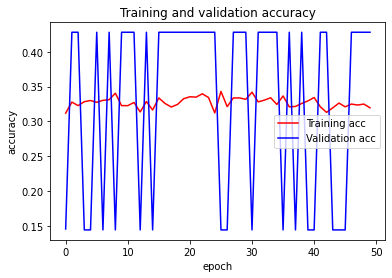

In [19]:
acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']
loss = classifier.history['loss']
val_loss = classifier.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.plot()

#Training and Validation Loss Graph#

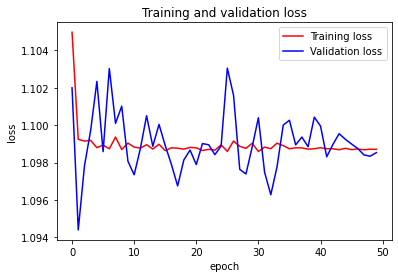

In [20]:
acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']
loss = classifier.history['loss']
val_loss = classifier.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()


#Final Prediction#

Text(0, 0.5, 'pneumonia')

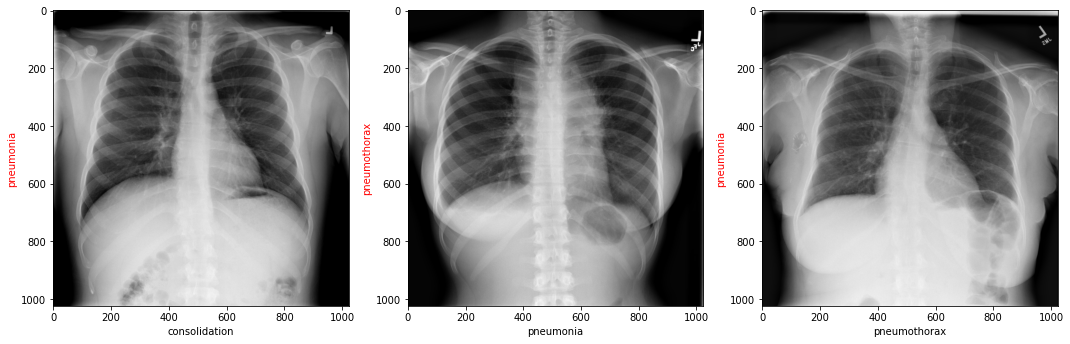

In [23]:
fig = plt.figure(figsize=(18, 10))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
ImagePath = '/content/NIH Chest X-ray Dataset/validation/consolidation/00018416_000.png'
Image = cv2.imread(ImagePath)
test_image = image.load_img(ImagePath,target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = cnn.predict(test_image)

plt.imshow(Image)
col = 'green' if labels[0] == labels[np.argmax(result)] else 'red'
plt.xlabel(labels[0])
plt.ylabel(labels[np.argmax(result)], color=col)

fig.add_subplot(rows, columns, 2)

ImagePath = '/content/NIH Chest X-ray Dataset/validation/pneumonia/00013798_000.png'
test_image = image.load_img(ImagePath,target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = cnn.predict(test_image)
Image = cv2.imread(ImagePath)

plt.imshow(Image)
col = 'green' if labels[1] == labels[np.argmax(result)] else 'red'
plt.xlabel(labels[1])
plt.ylabel(labels[np.argmax(result)], color=col)

fig.add_subplot(rows, columns, 3)
ImagePath = '/content/NIH Chest X-ray Dataset/validation/pneumothorax/00016128_001.png'
Image = cv2.imread(ImagePath)
test_image = image.load_img(ImagePath,target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = cnn.predict(test_image)

plt.imshow(Image)
col = 'green' if labels[2] == labels[np.argmax(result)] else 'red'
plt.xlabel(labels[2])
plt.ylabel(labels[np.argmax(result)], color=col)

##Confusion Matrix##

In [29]:
def plot_confusion_matrix(cm, classes, normalize = True, title = 'Confusion matrix', cmap = plt.cm.Reds):
    plt.figure(figsize = (10,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, fontsize = 10)
    plt.yticks(tick_marks, classes, fontsize = 10)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        cm = np.around(cm, decimals = 2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 13)
    plt.xlabel('Predicted Label', fontsize = 13)

In [30]:
target_names = ['consolidation', 'pneumonia', 'pneumothorax']

Y_pred = cnn.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

Confusion Matrix
Normalized confusion matrix


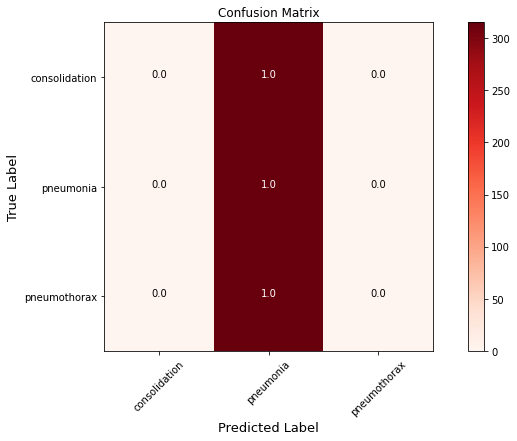

In [31]:
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
plot_confusion_matrix(cm, target_names, title = 'Confusion Matrix')

In [32]:
print('                      Classification Report')
print()
print(classification_report(test_set.classes, y_pred, target_names = target_names))

                      Classification Report

               precision    recall  f1-score   support

consolidation       0.00      0.00      0.00       315
    pneumonia       0.33      1.00      0.50       315
 pneumothorax       0.00      0.00      0.00       315

     accuracy                           0.33       945
    macro avg       0.11      0.33      0.17       945
 weighted avg       0.11      0.33      0.17       945



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
